## This notebook shows how to use Orchestrator APIs for user experiments

In [1]:
import os
import sys
import time
import logging
import subprocess
import threading
import json
from IPython.display import display
import ipywidgets as widgets
from subprocess import PIPE, STDOUT
from fabrictestbed.slice_manager import SliceManager, Status, SliceState

In [2]:
bastion_public_addr = 'bastion-1.fabric-testbed.net'
bastion_private_ipv4_addr = '192.168.11.226'
bastion_private_ipv6_addr = '2600:2701:5000:a902::c'

bastion_username = 'kissel'

bastion_key_filename = os.environ['HOME'] + "/.ssh/id_rsa"

ssh_key_file_priv=os.environ['HOME']+"/.ssh/id_rsa"
ssh_key_file_pub=os.environ['HOME']+"/.ssh/id_rsa.pub"

ssh_key_pub = None
with open (ssh_key_file_pub, "r") as myfile:
    ssh_key_pub=myfile.read()
    ssh_key_pub=ssh_key_pub.strip()

In [3]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
#credmgr_host = "cm.fabric-testbed.net"
print(f"FABRIC Credential Manager   : {credmgr_host}")

orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
#orchestrator_host = "orchestrator.fabric-testbed.net"
print(f"FABRIC Orchestrator         : {orchestrator_host}")

print (ssh_key_pub)

FABRIC Credential Manager   : cm.fabric-testbed.net
FABRIC Orchestrator         : orchestrator.fabric-testbed.net
ssh-rsa AAAAB3NzaC1yc2EAAAABIwAAAQEAqJzOPz82FFxuEx7Q3XX+fnF2v/PXaUhNLxayzYsvooykhQjQw8NbLhmOSYxQ96H/yAv+TuxMrDse9A4FhUiz55bfTvf7vINg3FFxfXIdwAj82Q2ZPccdtFYcO0BQDGcCAjJPXXFBTdw1k8nnFN/zDyRwPArZKJ1RJWL+uochjSkKm3egASF2TBPJ1MpPvTfsG/IrXLJ2sH6Pa1oDPHnk5ZpU4OaKBW4vKjTcqqE3Pk8Qp+SpWKzc8ZMTtqeurWH8hzitUxuaxVMwmHIRM9iFg2MQIFGGIMCtqnY2Uqbf5CnlG52JRS0/MTSypd1FM3XqVCZJcchFZKJ7kBnt8bTd7Q== ezra@beesam


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [4]:
slice_manager = SliceManager(oc_host=orchestrator_host, 
                             cm_host=credmgr_host ,
                             project_name='all', 
                             scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [5]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: UTAH: { cpu: 10/10 , core: 304/320 , ram: 2,496/2,560 G, disk: 116,320/116,400 G, unit: 5/5 }
	Components:
		GPU-RTX6000:  GPU RTX6000 { unit: 5/5 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 15,360/15,360 G, unit: 16/16 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 627/635 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 4/4 }
	Site Interfaces:
		UTAH_STAR: TrunkPort { bw: 100/100 Gbps}
		UTAH_TACC: TrunkPort { bw: 100/100 Gbps}
NCSA: { cpu: 6/6 , core: 180/192 , ram: 1,476/1,536 G, disk: 60,300/60,600 G, unit: 3/3 }
	Components:
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 378/381 }
		NVME-P4510:  NVME P4510 { disk: 8,640/9,600 G, unit: 9/10 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 3/3 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }


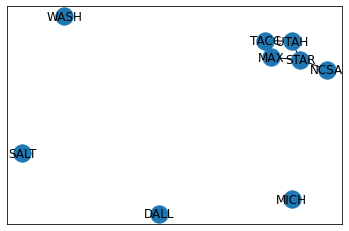

In [31]:
if status == Status.OK:
    advertised_topology.draw()

In [6]:
import time
import paramiko
from ipaddress import ip_address, IPv4Address
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType, Labels

def delete_slice(slice):
    return_status, result = slice_manager.delete(slice_object=slice)
    print("Response Status {}".format(return_status))
    print("Response received {}".format(result))

def delete_all_slices():
    return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])
    if return_status == Status.OK:
        for slice in slices:
            delete_slice(slice)
    
def validIPAddress(IP: str) -> str:
    try:
        return "IPv4" if type(ip_address(IP)) is IPv4Address else "IPv6"
    except ValueError:
        return "Invalid"

def wait_for_slice(slice_name, slice,timeout=180,interval=10,progress=False):
    timeout_start = time.time()

    if progress: print("Waiting for slice .", end = '')
    while time.time() < timeout_start + timeout:
        return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

        if return_status == Status.OK:
            slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
            if slice.slice_state == "StableOK":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice
            if slice.slice_state == "Closing" or slice.slice_state == "Dead":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice    
        else:
            print(f"Failure: {slices}")
        
        if progress: print(".", end = '')
        time.sleep(interval)
    
    if time.time() >= timeout_start + timeout:
        if progress: print(" Timeout exceeded ({} sec). Slice: {} ({})".format(timeout,slice.slice_name,slice.slice_state))
        return slice   

def do_test(slice_name, nnodes, site, worker, results=tuple()):
    # XXX static params
    network_service_name='bridge1'
    username = 'ubuntu'
    image = 'default_ubuntu_20'
    image_type = 'qcow2'
    cores = 2
    ram = 8
    disk = 10

    print ("Executing: ", slice_name, nnodes, site, worker)

    # Create topology
    t = ExperimentTopology()

    # Specify exact component if set
    labels = Labels()
    if worker:
        labels.instance_parent = worker

    # Add nodes
    for i in range(0, nnodes):
        nname = f"node{i}"
        nic_name = f"{nname}-nic1"
    
        node = t.add_node(name=nname, site=site)
    
        # Set capacities
        cap = Capacities()
        cap.set_fields(core=cores, ram=ram, disk=disk)

        # Set Properties
        node.set_properties(capacities=cap, image_type=image_type, image_ref=image, labels=labels)

        # Shared Cards
        node.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name=nic_name)

    # L2Bridge Service
    t.add_network_service(name=network_service_name, nstype=ServiceType.L2Bridge, interfaces=t.interface_list)

    # Generate Slice Graph
    slice_graph = t.serialize()

    # Request slice from Orchestrator
    return_status, slice_reservations = slice_manager.create(slice_name=slice_name, 
                                                slice_graph=slice_graph, 
                                                ssh_key=ssh_key_pub)

    if return_status == Status.OK:
        slice_id = slice_reservations[0].get_slice_id()
        print("Submitted slice creation request. Slice ID: {}".format(slice_id))
    else:
        print(f"Failure: {slice_reservations}")
        return 
    
    return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

    if return_status == Status.OK:
        time.sleep(2)
        slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
        slice = wait_for_slice(slice_name, slice, progress=True)

    print()
    print("Slice Name : {}".format(slice.slice_name))
    print("ID         : {}".format(slice.slice_id))
    print("State      : {}".format(slice.slice_state))
    print("Lease End  : {}".format(slice.lease_end))
 
    return_status, experiment_topology = slice_manager.get_slice_topology(slice_object=slice)
    slivers = slice_manager.slivers(slice_object=slice)
    #print (slivers)
    
    time.sleep(15)
 
    node_addrs = list()
    for i in range(0, nnodes):
        nname = f"node{i}"
        node = experiment_topology.nodes[nname]

        management_ip = str(node.get_property(pname='management_ip'))
        print("Node Name        : {}".format(node.name))
        print("Management IP    : {}\n".format(management_ip))
        node_addrs.append(management_ip)
        
    key = paramiko.RSAKey.from_private_key_file(ssh_key_file_priv)

    bastion=paramiko.SSHClient()
    bastion.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    bastion.connect(bastion_public_addr, username=bastion_username, key_filename=bastion_key_filename)
    bastion_transport = bastion.get_transport()

    i = 1
    for addr in node_addrs:
        if validIPAddress(addr) == 'IPv4':
            src_addr = (bastion_private_ipv4_addr, 22)
        elif validIPAddress(addr) == 'IPv6':
            src_addr = (bastion_private_ipv6_addr, 22)
        else:
            print('Management IP Invalid: {}'.format(addr))
            return slice, slivers, "error"

        dest_addr = (addr, 22)
        bastion_channel = bastion_transport.open_channel("direct-tcpip", dest_addr, src_addr)

        client = paramiko.SSHClient()
        client.load_system_host_keys()
        client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
        client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

        client.connect(addr,username=username,pkey = key, sock=bastion_channel)
    
        print (f"Setting iface config on {addr} (node{i-1})")
        stdin, stdout, stderr = client.exec_command(f"sudo ip addr add 192.168.10.{i}/24 dev ens7")
        print (str(stdout.read(),'utf-8').replace('\\n','\n'))

        stdin, stdout, stderr = client.exec_command('sudo ip link set ens7 up && ip addr show dev ens7')
        print (str(stdout.read(),'utf-8').replace('\\n','\n'))

        client.close()
        i += 1

        
    # Ping from node0 to the others
    addr = node_addrs[0]

    dest_addr = (addr, 22)
    bastion_channel = bastion_transport.open_channel("direct-tcpip", dest_addr, src_addr)

    client = paramiko.SSHClient()
    client.load_system_host_keys()
    client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
    client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

    client.connect(addr,username=username,pkey = key, sock=bastion_channel)

    rstr = str()
    for i in range(1, nnodes+1):
        stdin, stdout, stderr = client.exec_command(f"ping -c 2 192.168.10.{i}")
        rstr += (str(stdout.read(),'utf-8').replace('\\n','\n'))
    
    results = (slice, slivers, rstr)
    return slice, slivers, rstr

In [7]:
delete_all_slices()

Response Status Status.OK
Response received None


In [8]:
slice_name = 'ETestSlice'
site = 'UTAH'
#worker = 'utah-w5.fabric-testbed.net'
worker = None
nnodes = 8
ntests = 16

for i in range(0, ntests):
    result = tuple()
    slice, slivers, rstr = do_test(f"{slice_name}{i}", nnodes, site, worker, result)
    if (rstr == "error"):
        print (slice)
        print (slivers)
    else:
        print (rstr)
        if rstr.find("100% packet loss") != -1:
            print (slivers)
            print("FOUND BAD SLICE")
            break
    delete_slice(slice)

Executing:  ETestSlice0 8 UTAH None
Submitted slice creation request. Slice ID: b9904d90-5ade-41f8-aaea-d10758e2882c
Waiting for slice .......... Slice state: StableOK

Slice Name : ETestSlice0
ID         : b9904d90-5ade-41f8-aaea-d10758e2882c
State      : StableOK
Lease End  : 2022-01-20 15:54:54
Node Name        : node0
Management IP    : 2001:1948:417:7:f816:3eff:feb2:37f1

Node Name        : node1
Management IP    : 2001:1948:417:7:f816:3eff:fe6f:af59

Node Name        : node2
Management IP    : 2001:1948:417:7:f816:3eff:fe36:e900

Node Name        : node3
Management IP    : 2001:1948:417:7:f816:3eff:febf:fad5

Node Name        : node4
Management IP    : 2001:1948:417:7:f816:3eff:fe86:cb71

Node Name        : node5
Management IP    : 2001:1948:417:7:f816:3eff:fee5:b11

Node Name        : node6
Management IP    : 2001:1948:417:7:f816:3eff:fe80:d07a

Node Name        : node7
Management IP    : 2001:1948:417:7:f816:3eff:fe2a:5297

Setting iface config on 2001:1948:417:7:f816:3eff:feb2